# Genotype data preprocessing

This document performs genotype data quality control and preprocessing, as outlined in the yellow boxes of the flowchart below.

![Data_proc_flowchart](../../../../_images/data_preprocessing.png)

## Overview

### Analysis steps

1. Genotype data quality control (QC). See here for the [QC default settings](https://cumc.github.io/xqtl-pipeline/pipeline/data_preprocessing/genotype/GWAS_QC.html).
2. Principle component analysis (PCA) based QC, and PC computation for each sub-population available in the genotype data.
3. Genomic relationship matrix (GRM) computation.
4. Genotype data reformatting for downstream fine-mapping analysis.

### Input data requirement

1. Genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/pipeline/data_preprocessing/genotype/genotype_formatting.html).
2. [Optional] a sample information file to specific population information, if external data such as HapMap or 1000 Genomes are to be integrated to the PCA analysis to visualize and assess population structure in the genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/pipeline/data_preprocessing/genotype/genotype_formatting.html).

## Genotype QC for PCA

In [ ]:
sos run genotype_formatting.ipynb merge_plink \
    --genoFile data/genotype/chr1.bed data/genotype/chr6.bed \
    --cwd output/genotype \
    --name chr1_chr6 \
    --container container/bioinfo.sif

Determine and split between related and unrelated individuals,

In [ ]:
sos run GWAS_QC.ipynb king \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.bed \
    --name 20220110 \
    --container container/bioinfo.sif

Variant level and sample level QC on unrelated individuals using MAF>5% variants, in preparation for PCA analysis:

In [ ]:
sos run GWAS_QC.ipynb qc \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.unrelated.bed \
    --maf-filter 0.05 \
    --name for_pca \
    --container container/bioinfo.sif

Extract previously selected variants from related individuals in preparation for PCA, only applying missingness filter at sample level,

In [ ]:
sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.related.bed \
    --keep-variants output/genotype/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.in \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name for_pca \
    --container container/bioinfo.sif

## Principle component analysis

Analysis below uses data from previous genotype QC. This is a simple data-set containing what we believe a homogenous (European) samples. 

First, perform PCA on unrelated individuals after QC in previous step,

In [ ]:
sos run PCA.ipynb flashpca \
        --cwd output/pca \
        --genoFile output/genotype/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.bed \
        --phenoFile output/genotype/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.fam \
        --container container/flashpcaR.sif

> /home/gw/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.pca.pc.png (1.4 MiB):

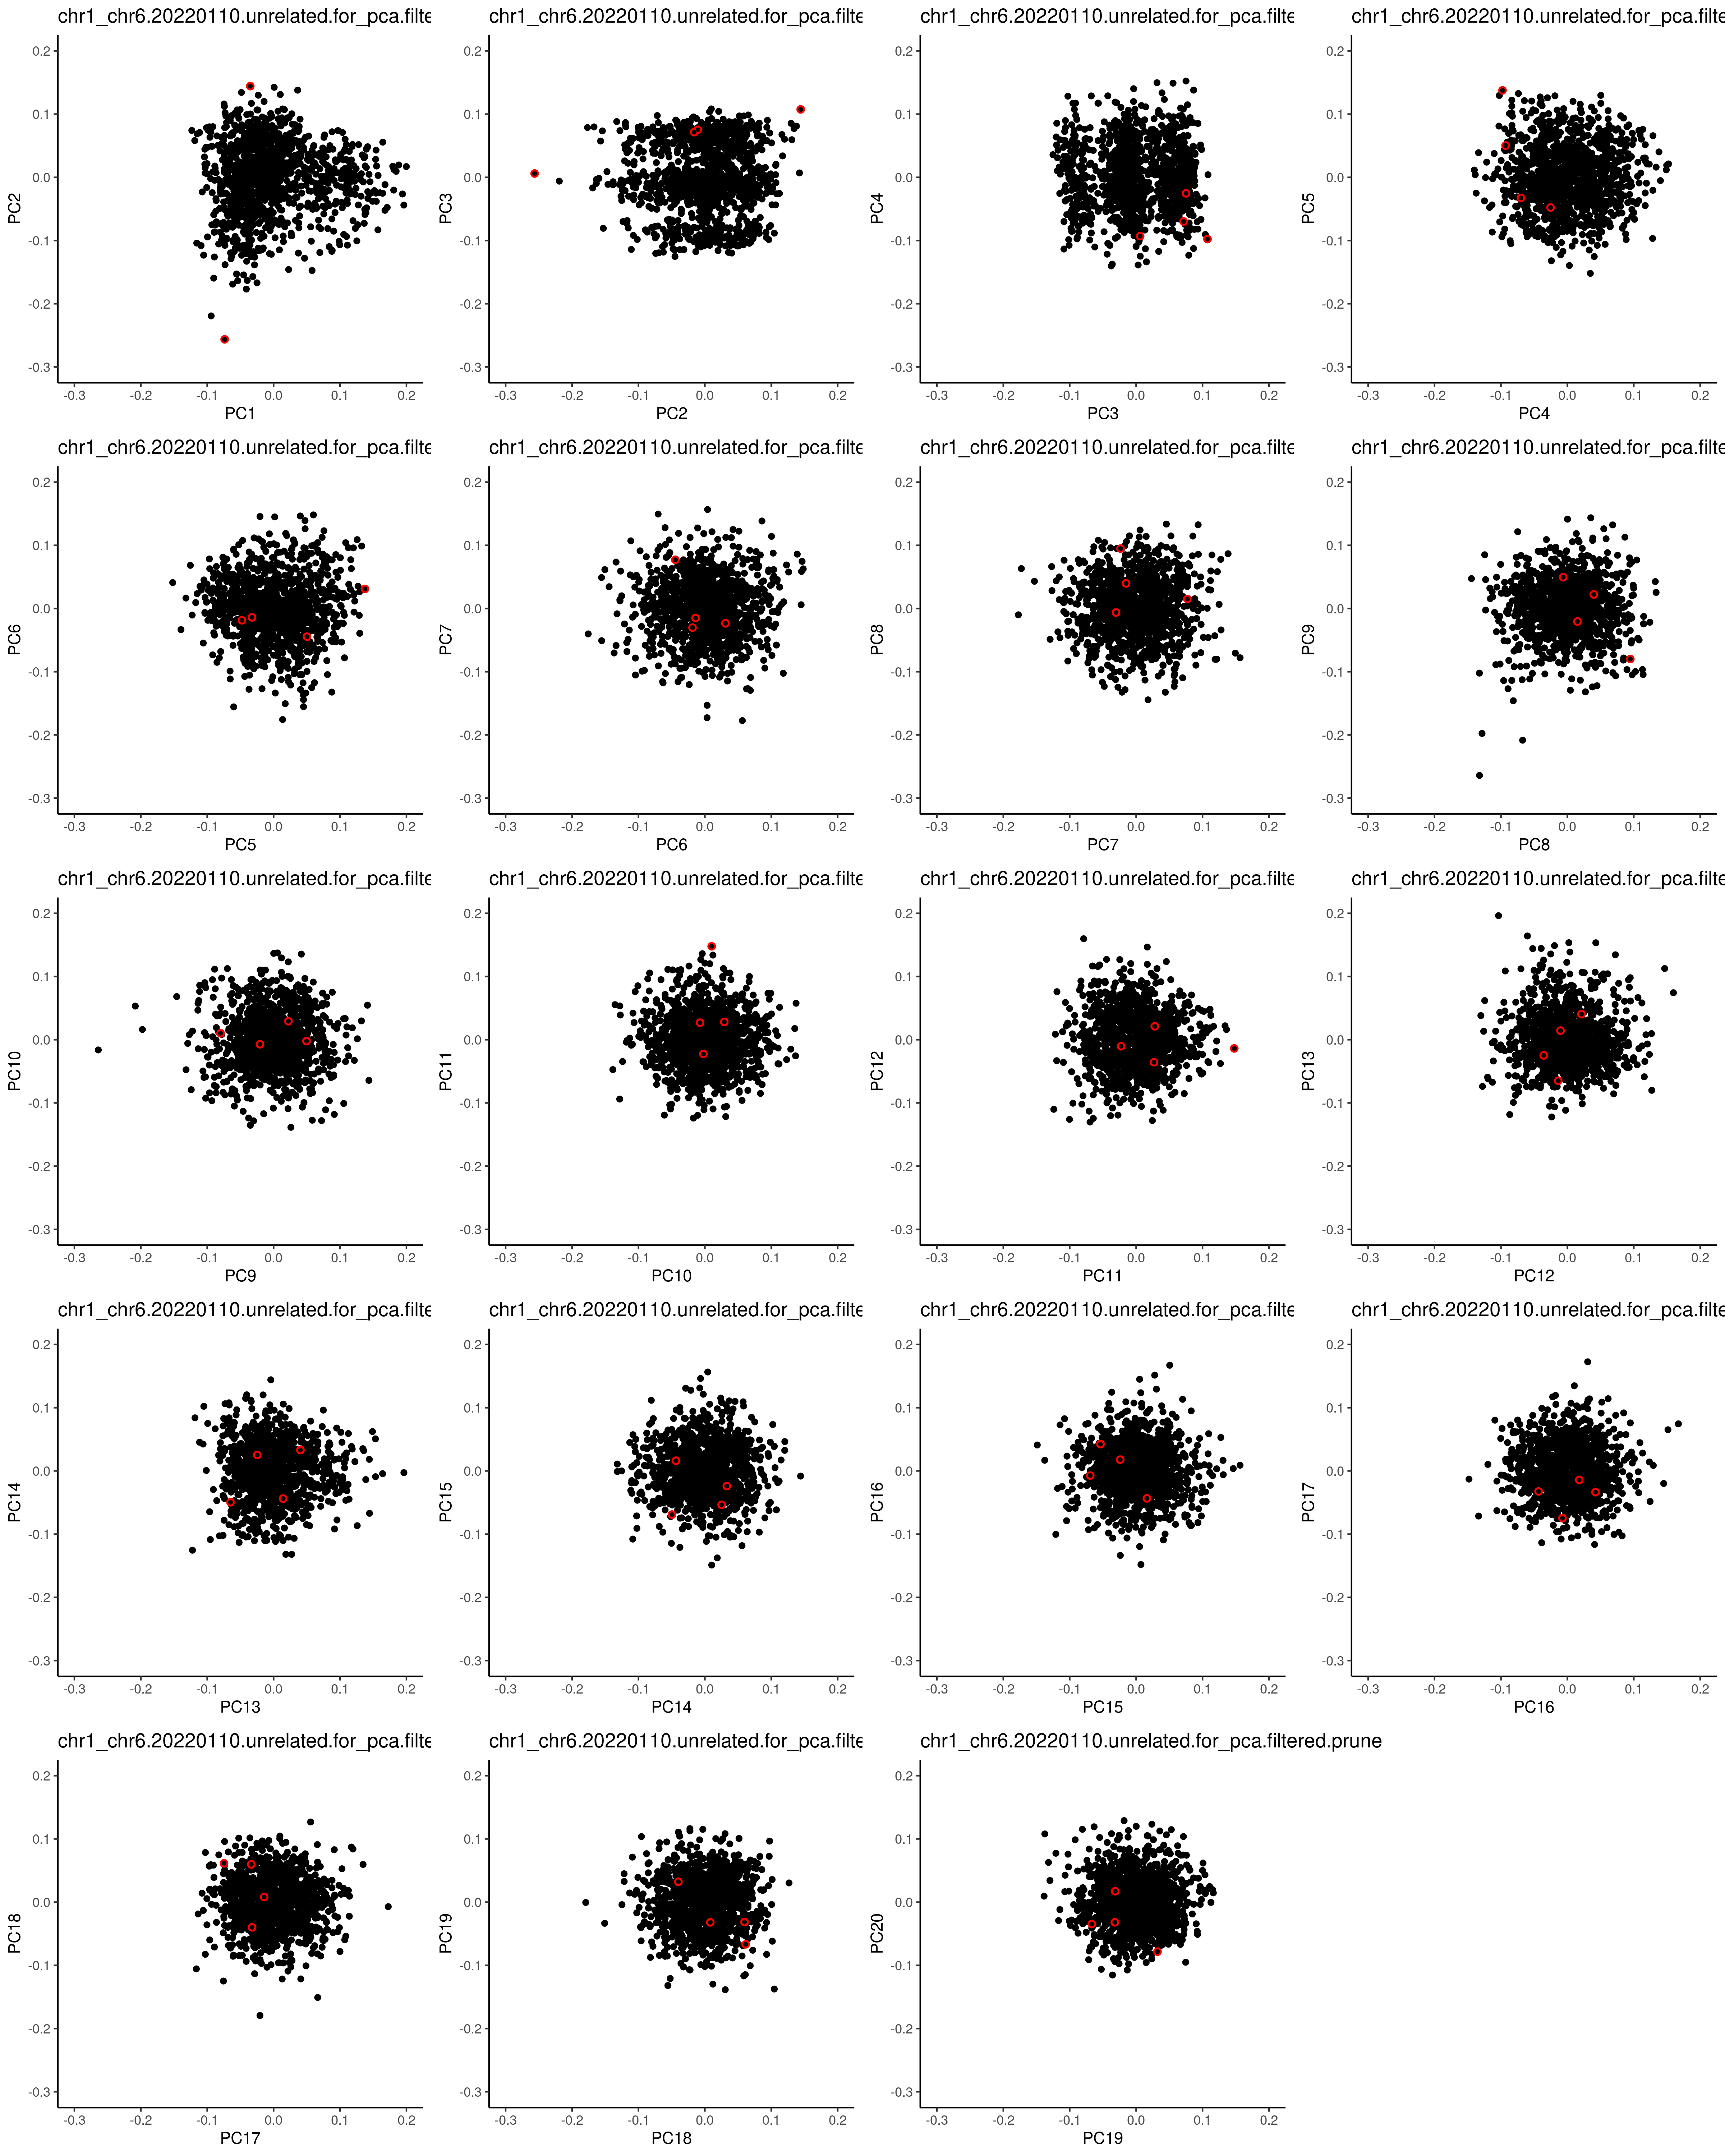

In [2]:
%preview ~/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.pca.pc.png

> /home/gw/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.pca.scree.png (56.7 KiB):

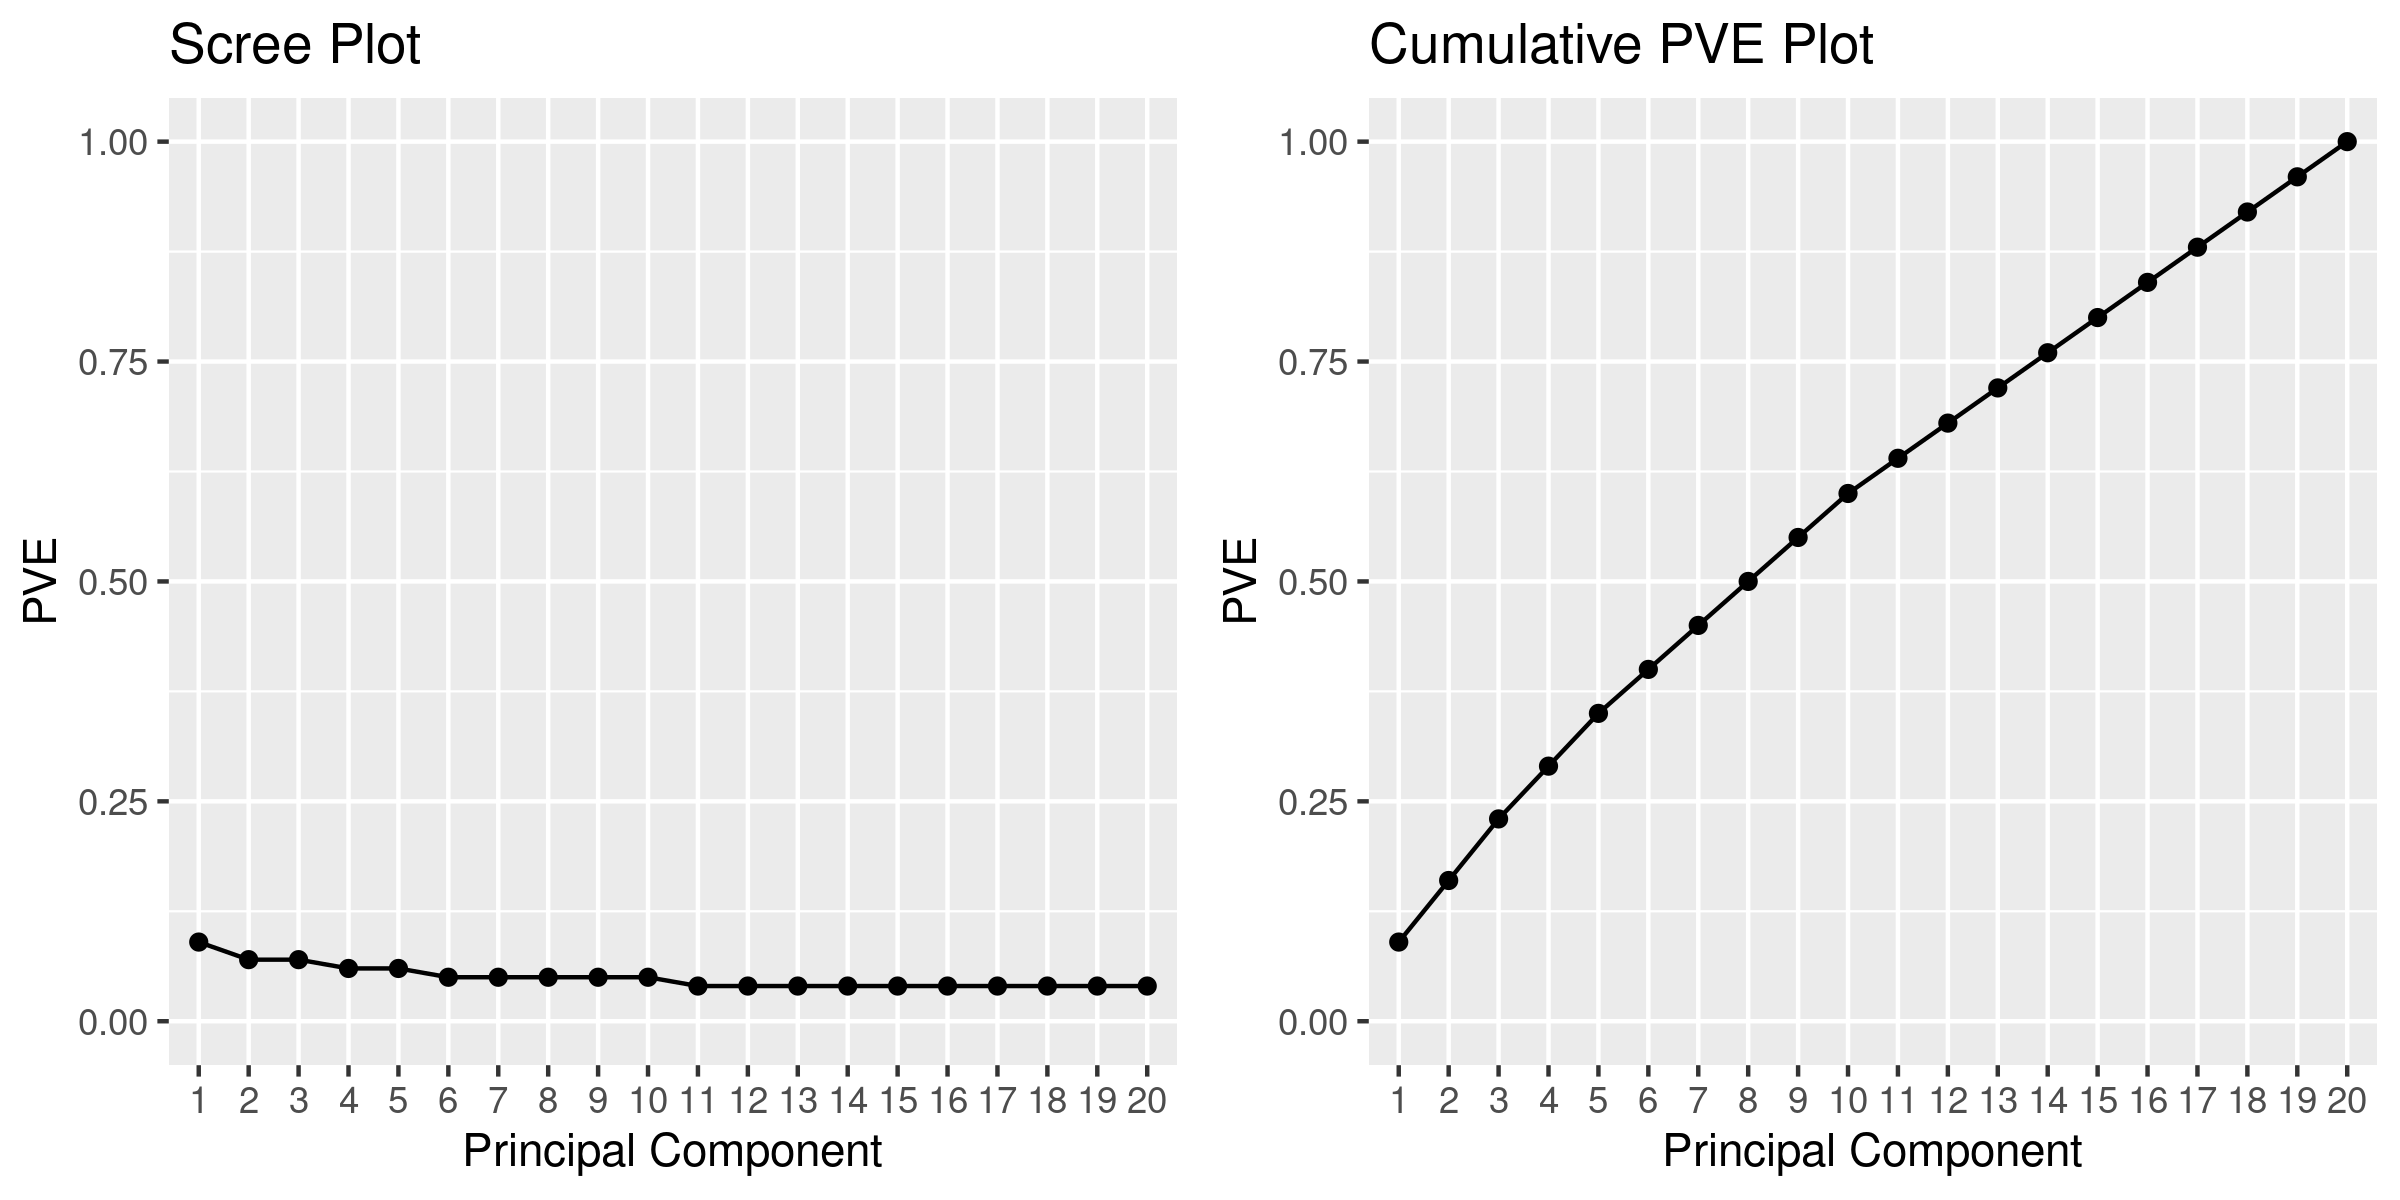

In [3]:
%preview ~/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.pca.scree.png

Then project back related individuals to the space spanned by PC from unrelated individuals, and detect PC outliers. 

**Notice here that you need to decide how many PCs to use to compute outliers (the `--maha-k` parameter), based on the PC scree plot. You should include a decent number of PCs that capture enough variation in genotype data. Please manually examine the PC plot before running this command.**

In [ ]:
sos run PCA.ipynb project_samples \
  --cwd output/pca \
  --genoFile output/genotype/chr1_chr6.20220110.related.for_pca.filtered.extracted.bed \
  --phenoFile output/genotype/chr1_chr6.20220110.related.for_pca.filtered.extracted.fam \
  --pca-model output/pca/chr1_chr6.20220110.unrelated.for_pca.filtered.prune.pca.rds \
  --maha-k 5 \
  --container container/flashpcaR.sif

> /home/gw/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.pc.png (1.4 MiB):

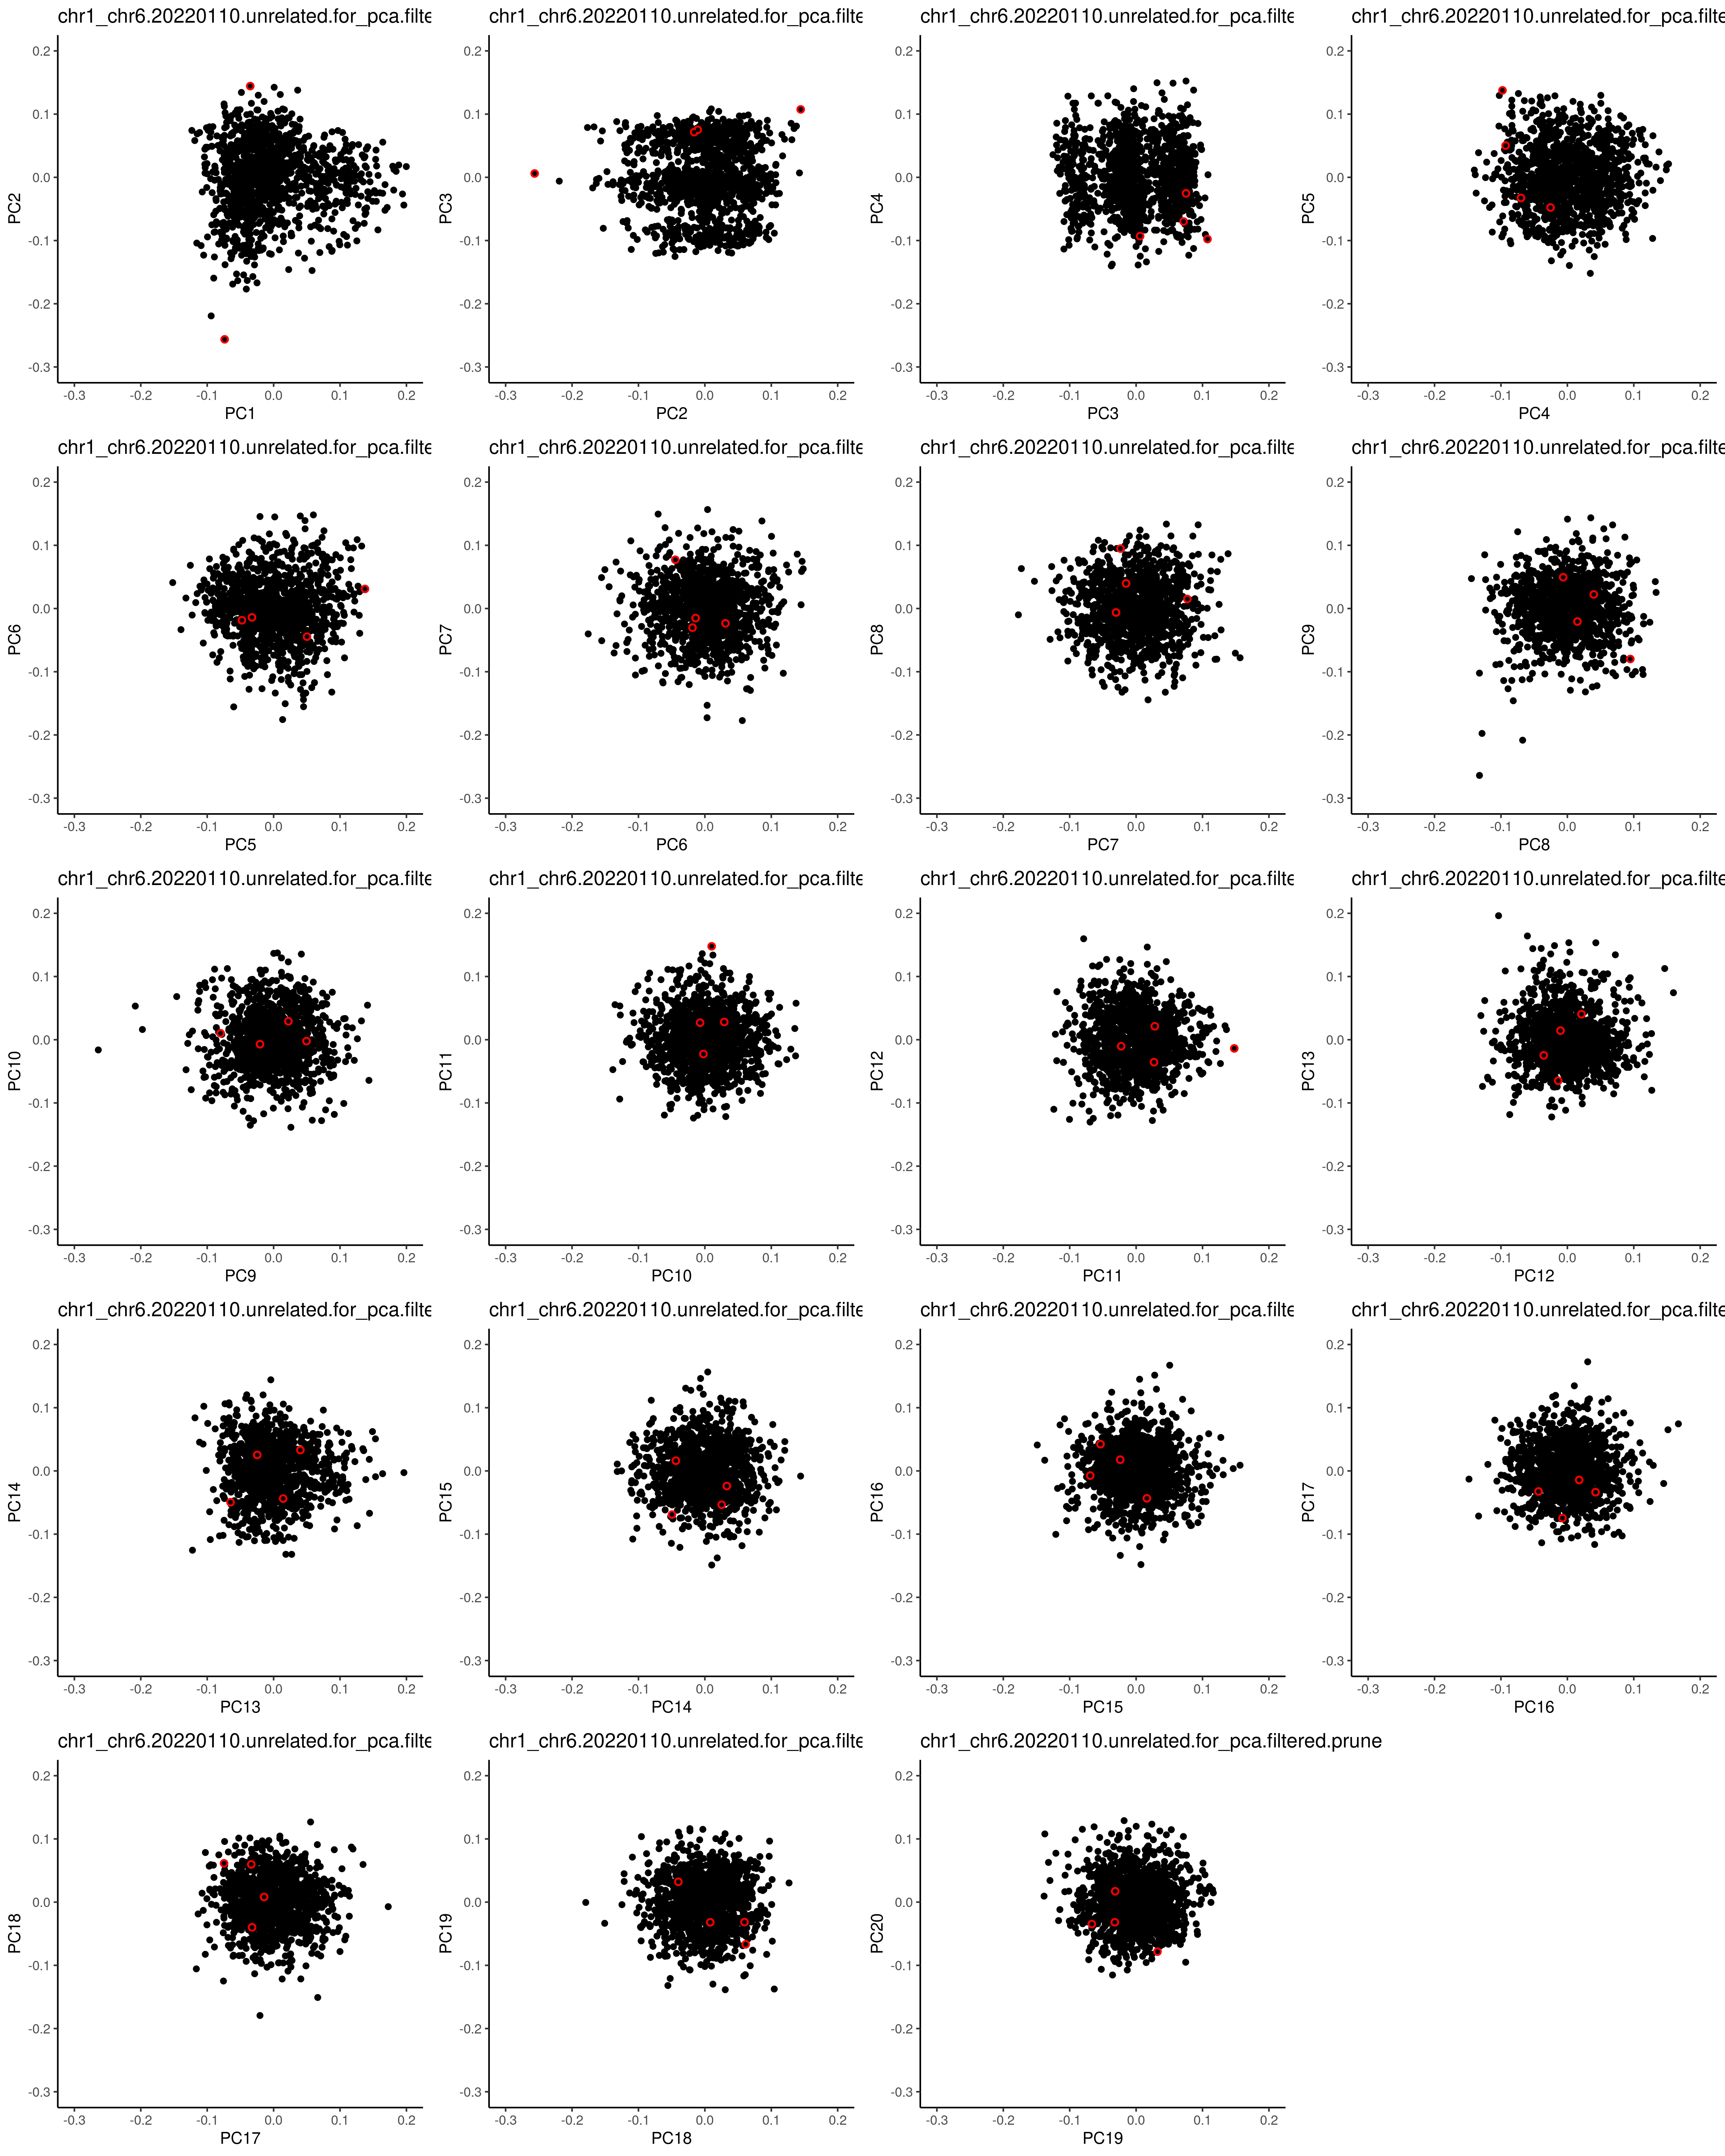

In [4]:
%preview ~/tmp/19-Jan-2022/output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.pc.png

## Finalized genotype QC as a result of PCA

### For all variants

PCA analysis can possibly provide us a list of outlier samples to be removed from the genotype data. We can optionally remove them and perform genotype data QC, similar to our initial QC but without LD pruning:

In [ ]:
sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.unrelated.bed \
    --remove-samples output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.outliers \
    --name no_outlier \
    --container container/bioinfo.sif

Also remove outliers and keep the same variant as unrelated individuals, in related individuals:

In [ ]:
sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.related.bed \
    --remove-samples output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.outliers \
    --keep-variants output/genotype/chr1_chr6.20220110.unrelated.no_outlier.filtered.bim \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name no_outlier \
    --container container/bioinfo.sif

Finally, merge back related and unrelated individuals as finalized genotype in PLINK format,

In [ ]:
sos run genotype_formatting.ipynb merge_plink \
    --genoFile output/genotype/chr1_chr6.20220110.unrelated.no_outlier.filtered.bed \
               output/genotype/chr1_chr6.20220110.related.no_outlier.filtered.extracted.bed \
    --cwd output/genotype_final \
    --name chr1_chr6_20220110_qced \
    --container container/bioinfo.sif

To fully illustrate how PCA and PCA based QC is done on sample with **multiple populations (a more complicated but potentially very useful setting)**, please try out the example documented in the [PCA analysis module](genotype/PCA.html) with a different example data-set.

### For common variants

Additionally, we provide a version with variants having sample minor allele frequency MAF > 1%, for the sake of convenience focusing our analysis on common variants:

In [ ]:
maf="01"

sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.unrelated.bed \
    --remove-samples output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.outliers \
    --maf-filter 0.$maf \
    --name no_outlier_maf0p$maf \
    --container container/bioinfo.sif

sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/chr1_chr6.20220110.related.bed \
    --remove-samples output/pca/chr1_chr6.20220110.related.for_pca.filtered.extracted.pca.projected.outliers \
    --keep-variants output/genotype/chr1_chr6.20220110.unrelated.no_outlier_maf0p$maf.filtered.bim \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name no_outlier_maf0p$maf \
    --container container/bioinfo.sif

sos run genotype_formatting.ipynb merge_plink \
    --genoFile output/genotype/chr1_chr6.20220110.unrelated.no_outlier_maf0p$maf.filtered.bed \
               output/genotype/chr1_chr6.20220110.related.no_outlier_maf0p$maf.filtered.extracted.bed \
    --cwd output/genotype_final \
    --name chr1_chr6_20220110_qced_maf0p$maf \
    --container container/bioinfo.sif

**FIXME: workflow below still needs to be tested and polished up by Gao Wang. They are not ready to reproduce**

## Genomic relationship matrix
input:
1. A list of plink trio per chrom, output from Genotype QC

output: 
1. A collection of ld.rds file that are suitable for mvsusie_rss and susie_rss
2. One row of the LD recipe file for this particular theme, so that susie_rss can find the correct ld

In [ ]:
nohup sos run GRM.ipynb GRM
    --genotype_list demo.processed_genotype.plink_per_chrom.recipe \
    --wd GRM/ \
    --name "demo" \
    --container "base-bioinfo.sif" 

## Reformatting and partition for regional genotypic data

In [ ]:

nohup sos run plink2vcf\
    --genoFile ac.mergrd.ac.filtered.prune.bed \
    --wd genotype_reformmating/ \
    --name "ac" \
    --region_list geneTpmResidualsAgeGenderAdj_rename_region_list.txt  \
    --container "base-bioinfo.sif" 

nohup sos run genotype_formatting.ipynb plink_by_gene \
    --genoFile ac.mergrd.ac.filtered.prune.bed \
    --wd genotype_reformmating/ \
    --name "dlpfc" \
    --region_list mwe_region  \
    --container "base-bioinfo.sif" 

nohup sos run genotype_formatting.ipynb plink_by_chrom \
    --genoFile ac.mergrd.ac.filtered.prune.bed \
    --wd genotype_reformmating/ \
    --name "pcc" \
    --region_list mwe_region  \
    --container "base-bioinfo.sif" 